# Fitting raw sunspot data

In this notebook I will take a random sample of points from the raw data, which is very noisy and will prove more challenging to model than the smoothed SVG signal.

For this I will be using the ***qusi-periodic kernel function***, given by:

$$ k_{i,j} = A^2 \exp{\left[-\frac{(x_i-x_j)^2}{2 l^2} - \sin^2{\left(\frac{\pi (x_i - x_j)}{P} \right)} \right]} + \sigma^2 \delta_{ij}$$

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az

In [6]:
df = pd.read_csv (r'Data/Sunspots.csv') # importing raw data
xcol = 'Date'
ycol = 'Monthly Mean Total Sunspot Number'

X = (df[xcol].values)
y = df[ycol].values

In [7]:
from datetime import datetime

time = [datetime.strptime(X[i], '%Y-%m-%d')
       for i in range(len(X))]

In [8]:
rng = np.random.RandomState(7) # random selection of points
training_indices = rng.choice(np.arange(y.size), size=100, replace=False)

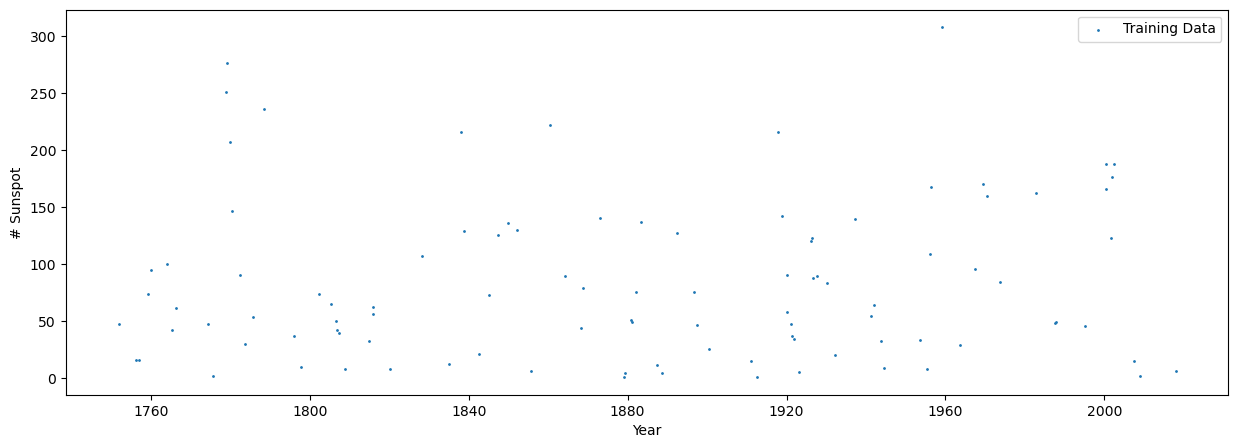

In [9]:
X_train = np.asarray([datetime.strptime(X[training_indices][i], '%Y-%m-%d') 
           for i in range(len(training_indices))]).reshape(-1,1)  # x & y values of random indicies
y_train = y[training_indices]

fig, ax = plt.subplots(1, dpi=100, figsize=[15,5])

ax.scatter(X_train, y_train, label='Training Data', s=1)
ax.set_xlabel('Year')
ax.set_ylabel("# Sunspot")
#ax.set_xticks
ax.legend();

Here we are taking a sample of points from our data (which contains over 70,000 datapoints). The training data represents most of the shape of the distribution, so we will observe how well it can be modelled using a Gaussian process.

PyMC3 doesn't contain the quasi-periodic kernel, but it *does* contain a **periodic kernel** as well as a **squared exponential kernel**, which we can multiply togehter to arrive at our desired kernel.

In [31]:
''' Need to convert the datetime into decimal years '''

# decimal_years =

' Need to convert the datetime into decimal years '

In [28]:
with pm.Model() as model:
    
    period = pm.Deterministic('Period',
                              pm.Beta('T', 2, 2) * 10 + 5)
    A = pm.Gamma('A', 2, 2)
    length_scale1 = pm.Deterministic('Length Scale 1', 
                                    pm.Beta('ls1', 2, 2) * 100)
    length_scale2 = pm.Deterministic('Length Scale 2', 
                                    pm.Beta('ls2', 2, 2)* 100)
    sigma = pm.Deterministic('$\sigma$',
                             pm.Beta('sigma', 2, 2) * 10)
    
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1) # periodic kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2) # squared exponential kernel
    cov_qp = A**2 * cov_SE * cov_periodic  # quasi-periodic kernel
    
    mu = pm.Normal('mu', 100, 50) # note: using LogNormal makes no difference
    const_func = pm.gp.mean.Constant(mu)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=const_func)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

TypeError: Unsupported dtype for TensorType: object

The above code required a lot of trial and error to see at which points the priors converge to their optimal values, and continued readjustment of priors eventually lead to the values we have below.

In [ ]:
az.plot_posterior(tr);

In [ ]:
X_new = np.linspace(1800, 2055, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=100, var_names=["f_new"])#

In [ ]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(18, 5))
ax = fig.gca()
plot_gp_dist(ax, ppc['f_new'], X_new, palette="Blues")

# plot original data and true function
plt.plot(X_train, y_train, "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, ms=1, alpha=0.1, color="black", label="All Data")

plt.xlabel("x")
plt.title("Posterior distribution over $f(x)$ at the observed values ($\sigma$=1)")
plt.legend();

#### Comment on plot:

The raw data is extremely noisy, and the GPR has a very difficult time trying to fit it . As a result I believe the best course of action is to simply fit the SVG smoothed signal, or try a different method.